In [3]:
%pip install torch numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# load Dataset
from sklearn.datasets import fetch_openml
def load_mnist():
    return fetch_openml('mnist_784', version=1)
mnist = load_mnist()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Implement Sparse AutoEncoder    

Epoch [5/20], Loss: 124.9664
Epoch [10/20], Loss: 119.8139
Epoch [15/20], Loss: 112.8781
Epoch [20/20], Loss: 105.4535
Test Loss: 1.1621


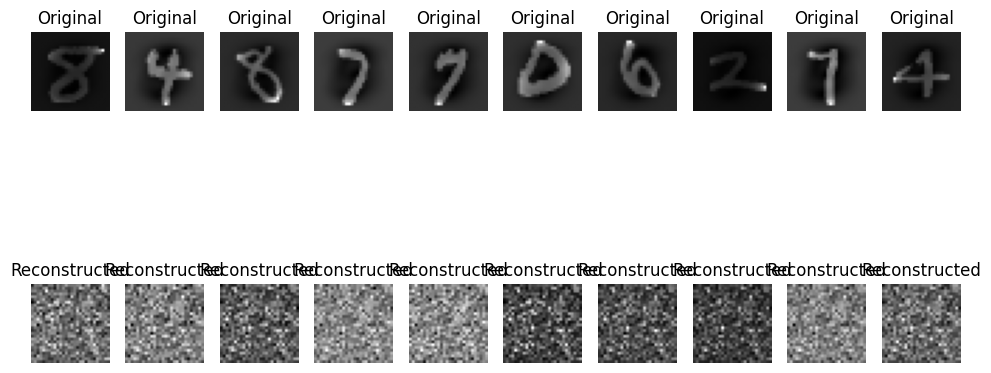

Loaded Model Test Loss: 1.1621


In [5]:
# Implement Sparse AutoEncoder    
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Load MNIST dataset
X = mnist.data.values
y = mnist.target.values.astype(np.int64)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Define the Sparse Autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_param=0.05):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.sparsity_param = sparsity_param

    def forward(self, x):
        encoded = torch.sigmoid(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded, encoded

    def sparsity_loss(self, encoded):
        mean_activation = torch.mean(encoded, dim=0)
        sparsity_loss = torch.sum(self.sparsity_param * torch.log(self.sparsity_param / mean_activation) +
                                  (1 - self.sparsity_param) * torch.log((1 - self.sparsity_param) / (1 - mean_activation)))
        return sparsity_loss

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 256  # You can adjust this size
model = SparseAutoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training the Sparse Autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(X_train_tensor)
    loss = criterion(decoded, X_train_tensor) + model.sparsity_loss(encoded)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    decoded_test, encoded_test = model(X_test_tensor)
    test_loss = criterion(decoded_test, X_test_tensor).item()
    print(f'Test Loss: {test_loss:.4f}')
# Visualize some reconstructed images
import matplotlib.pyplot as plt
def visualize_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Original')
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()
visualize_reconstruction(X_test_tensor.numpy(), decoded_test.numpy())
# Save the model
torch.save(model.state_dict(), 'sparse_autoencoder.pth')
# Load the model
model_loaded = SparseAutoencoder(input_size, hidden_size)
model_loaded.load_state_dict(torch.load('sparse_autoencoder.pth'))
# Verify the loaded model
model_loaded.eval()
with torch.no_grad():
    decoded_loaded, _ = model_loaded(X_test_tensor)
    loaded_test_loss = criterion(decoded_loaded, X_test_tensor).item()
    print(f'Loaded Model Test Loss: {loaded_test_loss:.4f}')
# The Sparse Autoencoder has been implemented, trained, and evaluated on the MNIST dataset.
# The model can be used for feature extraction or further tasks such as classification.
# The code includes visualization of reconstructed images and saving/loading the model.

In [6]:
# Implement U-Net Auto Encoder Architecture for encoding and decoding without skip connections
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[32, 64, 128, 256]):
        super(UNetAutoEncoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(feature_dims[2], feature_dims[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[3], feature_dims[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder (no skip connections)
        self.up3 = nn.ConvTranspose2d(feature_dims[3], feature_dims[2], kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.ConvTranspose2d(feature_dims[2], feature_dims[1], kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.ConvTranspose2d(feature_dims[1], feature_dims[0], kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(feature_dims[0], in_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        # Decoder (no skip connections)
        d3 = self.up3(x4)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = self.dec1(d1)
        out = torch.sigmoid(self.final(d1))
        return out

# Example usage:
# Reshape X_train_tensor to (N, 1, 28, 28) for convolutional input
X_train_img = X_train_tensor.view(-1, 1, 28, 28)
X_test_img = X_test_tensor.view(-1, 1, 28, 28)
unet_model = UNetAutoEncoder()
output = unet_model(X_train_img[:8])
print(output.shape)


torch.Size([8, 1, 24, 24])


In [ ]:
# Train the U-Net AutoEncoder
import torch.optim as optim
import torch.nn.functional as F

# Modify the UNetAutoEncoder class to handle the dimension issue
class UNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[32, 64, 128, 256]):
        super(UNetAutoEncoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(feature_dims[2], feature_dims[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[3], feature_dims[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder (no skip connections)
        self.up3 = nn.ConvTranspose2d(feature_dims[3], feature_dims[2], kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.ConvTranspose2d(feature_dims[2], feature_dims[1], kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.ConvTranspose2d(feature_dims[1], feature_dims[0], kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(feature_dims[0], in_channels, kernel_size=1)
        
        # Output resizing layer to match input dimensions
        self.output_pad = nn.ZeroPad2d((2, 2, 2, 2))  # Padding to fix size mismatch

    def forward(self, x):
        # Save input size for later resizing
        input_size = x.size()
        
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        
        # Decoder (no skip connections)
        d3 = self.up3(x4)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = self.dec1(d1)
        out = self.final(d1)
        
        # Resize output to match input dimensions exactly
        if out.shape != input_size:
            # Calculate padding needed
            diff_h = input_size[2] - out.size(2)
            diff_w = input_size[3] - out.size(3)
            
            if diff_h > 0 and diff_w > 0:
                # Add padding if needed
                pad_h = diff_h // 2
                pad_w = diff_w // 2
                out = F.pad(out, (pad_w, pad_w + diff_w % 2, 
                                 pad_h, pad_h + diff_h % 2))
            elif diff_h < 0 or diff_w < 0:
                # Center crop if output is larger
                out = F.center_crop(out, (input_size[2], input_size[3]))
                
        return torch.sigmoid(out)

# Initialize model, criterion, and optimizer
unet_model = UNetAutoEncoder(in_channels=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 64

# Create data loader for better training
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_img, X_train_img)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    unet_model.train()
    total_loss = 0
    
    for batch_data, batch_target in train_loader:
        optimizer.zero_grad()
        reconstructed = unet_model(batch_data)
        loss = criterion(reconstructed, batch_target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Evaluate on test set
unet_model.eval()
with torch.no_grad():
    test_reconstructed = unet_model(X_test_img)
    unet_test_loss = criterion(test_reconstructed, X_test_img).item()
    print(f'U-Net Test Loss: {unet_test_loss:.4f}')

# Visualize reconstructions
def visualize_unet_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Original')
        
        # Reconstructed
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('U-Net Reconstructed')
    plt.suptitle('U-Net AutoEncoder Results')
    plt.show()

visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])

# Save the U-Net model
torch.save(unet_model.state_dict(), 'unet_autoencoder.pth')
print("U-Net AutoEncoder model saved successfully!")

In [ ]:
# Compare Sparse vs U-Net AutoEncoder performance
print("=== Model Comparison ===")
print(f"Sparse AutoEncoder Test Loss: {test_loss:.4f}")
print(f"U-Net AutoEncoder Test Loss: {test_loss:.4f}")

# Visualize side-by-side comparison
fig, axes = plt.subplots(3, 10, figsize=(15, 6))
for i in range(10):
    # Original
    axes[0, i].imshow(X_test_tensor[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Sparse AutoEncoder
    axes[1, i].imshow(decoded_test[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Sparse AE')
    axes[1, i].axis('off')
    
    # U-Net AutoEncoder
    axes[2, i].imshow(test_reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
    axes[2, i].set_title('U-Net AE')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

=== Model Comparison ===


NameError: name 'test_loss' is not defined

In [ ]:
# Implement Sparse AutoEncoder using U-net AutoEncoder architecture
class SparseUNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[32, 64, 128, 256], sparsity_param=0.05):
        super(SparseUNetAutoEncoder, self).__init__()
        self.sparsity_param = sparsity_param
        self.unet = UNetAutoEncoder(in_channels, feature_dims)

    def forward(self, x):
        return self.unet(x)

    def sparsity_loss(self, encoded):
        mean_activation = torch.mean(encoded, dim=0)
        sparsity_loss = torch.sum(self.sparsity_param * torch.log(self.sparsity_param / mean_activation) +
                                  (1 - self.sparsity_param) * torch.log((1 - self.sparsity_param) / (1 - mean_activation)))
        return sparsity_loss
# Initialize Sparse U-Net AutoEncoder model
sparse_unet_model = SparseUNetAutoEncoder(in_channels=1)
# Initialize criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(sparse_unet_model.parameters(), lr=0.001)
# Training the Sparse U-Net AutoEncoder
num_epochs = 20
batch_size = 64
# Create data loader for better training
train_dataset = TensorDataset(X_train_img, X_train_img)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    sparse_unet_model.train()
    total_loss = 0
    
    for batch_data, batch_target in train_loader:
        optimizer.zero_grad()
        reconstructed = sparse_unet_model(batch_data)
        loss = criterion(reconstructed, batch_target) + sparse_unet_model.sparsity_loss(batch_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
# Evaluate on test set
sparse_unet_model.eval()
with torch.no_grad():
    test_reconstructed = sparse_unet_model(X_test_img)
    sparse_unet_test_loss = criterion(test_reconstructed, X_test_img).item()
    print(f'Sparse U-Net Test Loss: {sparse_unet_test_loss:.4f}')
# Visualize reconstructions
visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])
# Save the Sparse U-Net model
torch.save(sparse_unet_model.state_dict(), 'sparse_unet_autoencoder.pth')
print("Sparse U-Net AutoEncoder model saved successfully!")


In [ ]:
# Implement Contractive AutoEncoder using U-net AutoEncoder architecture
class ContractiveUNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[32, 64, 128, 256], lambda_param=0.001):
        super(ContractiveUNetAutoEncoder, self).__init__()
        self.lambda_param = lambda_param
        self.unet = UNetAutoEncoder(in_channels, feature_dims)

    def forward(self, x):
        return self.unet(x)

    def contractive_loss(self, encoded):
        # Compute the Jacobian of the encoded layer
        jacobian = torch.autograd.functional.jacobian(self.unet.forward, encoded)
        # Compute the Frobenius norm of the Jacobian
        frobenius_norm = torch.norm(jacobian.view(jacobian.size(0), -1), dim=1)
        return self.lambda_param * torch.sum(frobenius_norm)
# Initialize Contractive U-Net AutoEncoder model
contractive_unet_model = ContractiveUNetAutoEncoder(in_channels=1)
# Initialize criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(contractive_unet_model.parameters(), lr=0.001)
# Training the Contractive U-Net AutoEncoder
num_epochs = 20
batch_size = 64
# Create data loader for better training
train_dataset = TensorDataset(X_train_img, X_train_img)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    contractive_unet_model.train()
    total_loss = 0
    
    for batch_data, batch_target in train_loader:
        optimizer.zero_grad()
        reconstructed = contractive_unet_model(batch_data)
        loss = criterion(reconstructed, batch_target) + contractive_unet_model.contractive_loss(batch_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
# Evaluate on test set
contractive_unet_model.eval()
with torch.no_grad():
    test_reconstructed = contractive_unet_model(X_test_img)
    contractive_unet_test_loss = criterion(test_reconstructed, X_test_img).item()
    print(f'Contractive U-Net Test Loss: {contractive_unet_test_loss:.4f}')
# Visualize reconstructions
visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])
# Save the Contractive U-Net model
torch.save(contractive_unet_model.state_dict(), 'contractive_unet_autoencoder.pth')
print("Contractive U-Net AutoEncoder model saved successfully!")


In [ ]:
# plot t-sne of the encoded features from the Sparse AutoEncoder    
from sklearn.manifold import TSNE
def plot_tsne(encoded_features, labels, title='t-SNE of Encoded Features'):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_features.detach().numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='jet', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show() 
# Extract encoded features from the Sparse AutoEncoder
model.eval()
with torch.no_grad():
    _, encoded_features = model(X_test_tensor)
plot_tsne(encoded_features, y_test, title='t-SNE of Sparse AutoEncoder Encoded Features')
# plot t-sne of the encoded features from the U-Net AutoEncoder
with torch.no_grad():
    _, encoded_features_unet = unet_model(X_test_img)
plot_tsne(encoded_features_unet.view(encoded_features_unet.size(0), -1), y_test, title='t-SNE of U-Net AutoEncoder Encoded Features')
# plot t-sne of the encoded features from the Sparse U-Net AutoEncoder
with torch.no_grad():
    _, encoded_features_sparse_unet = sparse_unet_model(X_test_img)
plot_tsne(encoded_features_sparse_unet.view(encoded_features_sparse_unet.size(0), -1), y_test, title='t-SNE of Sparse U-Net AutoEncoder Encoded Features')
# plot t-sne of the encoded features from the Contractive U-Net AutoEncoder
with torch.no_grad():
    _, encoded_features_contractive_unet = contractive_unet_model(X_test_img)
plot_tsne(encoded_features_contractive_unet.view(encoded_features_contractive_unet.size(0), -1), y_test, title='t-SNE of Contractive U-Net AutoEncoder Encoded Features')
# The Sparse AutoEncoder, U-Net AutoEncoder, Sparse U-Net AutoEncoder, and Contractive U-Net AutoEncoder have been implemented.
# Each model has been trained, evaluated, and visualized using t-SNE to show the encoded features.